# This notebook goes over the implementation of Ostu's method for thresholding gray images. It contains optimizations for between and within class variance

## Imports

In [1]:
%pip install -q numpy pillow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Initialize

In [3]:
L = 256 # Gray levels
image_path = 'test.jpg'
image = Image.open(image_path).convert('L')
image_array = np.array(image)

In [4]:
def threshold_array(image_array:np.ndarray, k:int)->np.ndarray:
	'''Thresholds the input image_array with the given threshold k'''
	assert 0 <= k < L, f'Threshold must be between 0 and {255}'
	return np.where(image_array < k, 0, 1)

In [5]:
def get_pixel_values(image_array:np.ndarray)->np.ndarray:
	'''Returns N where each n_i is the number of pixels with gray level i in L'''
	array = np.zeros(L)
	for pixel_value in image_array.flatten():
		array[pixel_value] += 1
	return array

N = get_pixel_values(image_array)
P = N / np.sum(N)

assert np.abs(np.sum(P) - 1) < 1e-4, f'Sum of P is {np.sum(P)}, must be 1'
assert P.all()>=0, f'P has a negative value'

### Define statistial functions from paper

In [6]:
ω = lambda k: np.sum(P[:k+1])
μ = lambda k: np.sum([i*P[i] for i in range(k+1)])
var = lambda μ, range: np.sum([(i-μ)**2*P[i] for i in range])
μ_T = μ(L-1)

ω_0 = lambda k: ω(k)
ω_1 = lambda k: 1 - ω(k)
μ_0 = lambda k: μ(k) / ω_0(k)
μ_1 = lambda k: (μ_T - μ(k)) / ω_1(k)
var_0 = lambda k: var(μ_0(k), range(0,k+1))
var_1 = lambda k: var(μ_1(k), range(k+1, L))
var_W = lambda k: ω_0(k)*var_0(k) + ω_1(k)*var_1(k) # within class variance
var_B = lambda k: ω_0(k)*ω_1(k)*(μ_0(k) - μ_1(k))**2 # between class variance
var_T = lambda k: var_W(k) + var_B(k)
λ = lambda k: var_B(k) / var_W(k)
κ = lambda k: var_T(k) / var_B(k)
η = lambda k: var_B(k) / var_T(k)

## Optimize

In [7]:
between_class_variances = [var_B(i) for i in range(L)]
max_between_class_variance = np.argmax(between_class_variances)
max_between_class_variance

np.int64(59)

In [8]:
within_class_variances = [var_W(i) for i in range(L)]
min_within_class_variance = np.argmin(within_class_variances)
min_within_class_variance

np.int64(45)

## Visualize

In [9]:
def visualize_threshold(array, threshold):
	plt.figure()
	plt.hist(array.flatten(), bins=2)
	plt.xlabel('L')
	plt.ylabel('Pixel Count')
	plt.title(f'Threshold={threshold} Gray Level Histogram')
	plt.show()

def visualize_image(array, title):
	plt.figure()
	plt.imshow(array, cmap='gray')
	plt.title(title)
	plt.axis('off')
	plt.show()

### Original Grayscale Image

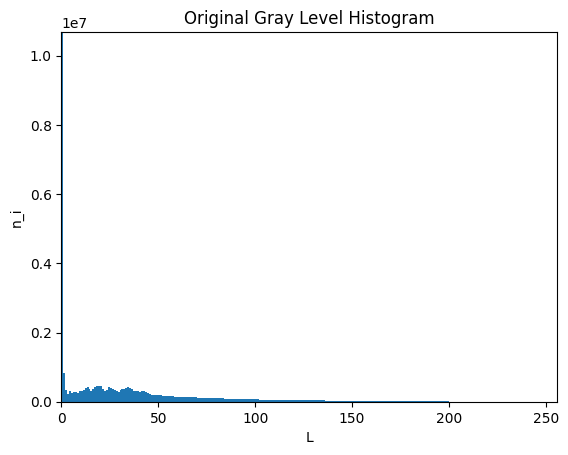

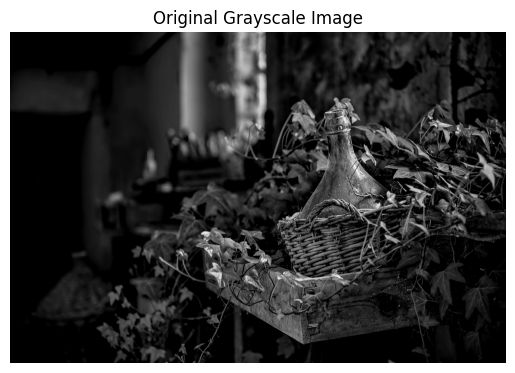

In [10]:
plt.figure()
plt.hist(image_array.flatten(), bins=range(L))
plt.xlim([0, L])
plt.ylim([0, np.max(N)])
plt.xlabel('L')
plt.ylabel('n_i')
plt.title('Original Gray Level Histogram')
plt.show()

visualize_image(image_array, 'Original Grayscale Image')

### Within Class Variance

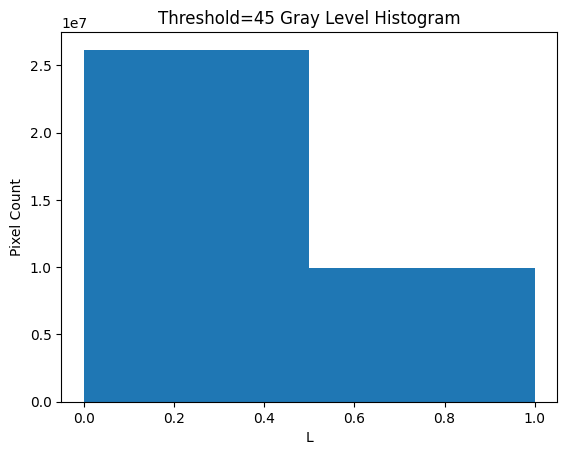

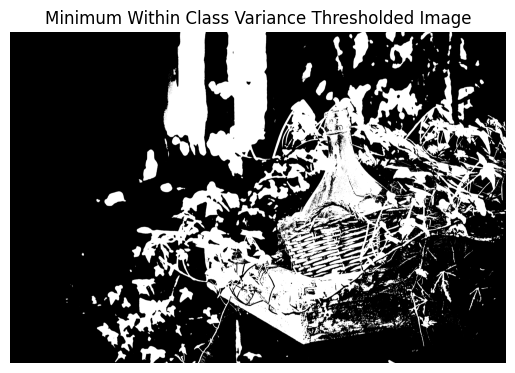

In [11]:
within_class_variance_array = threshold_array(image_array, min_within_class_variance)

visualize_threshold(within_class_variance_array, min_within_class_variance)
visualize_image(within_class_variance_array, 'Minimum Within Class Variance Thresholded Image')
Image.fromarray(within_class_variance_array.astype('uint8')*(L-1), 'L').save('within_class_variance.jpg')

### Between Class Variance

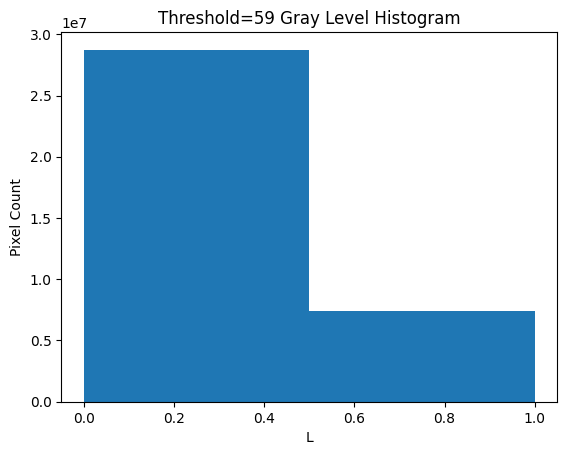

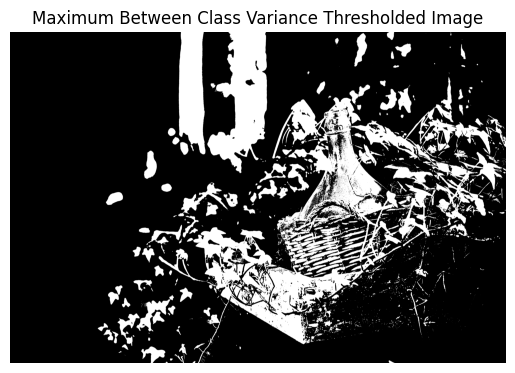

In [12]:

between_class_variance_array = threshold_array(image_array, max_between_class_variance)
visualize_threshold(between_class_variance_array, max_between_class_variance)
visualize_image(between_class_variance_array, 'Maximum Between Class Variance Thresholded Image')
Image.fromarray(between_class_variance_array.astype('uint8')*(L-1), 'L').save('between_class_variance.jpg')